In [1]:
!pip install kaggle

In [2]:
import os
os.makedirs('/root/.kaggle',exist_ok=True)
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d <dataset-indentifier>

mv: cannot stat 'kaggle.json': No such file or directory
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kaggle datasets download -d <dataset-indentifier>'


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 80% 65.0M/80.9M [00:00<00:00, 177MB/s]
100% 80.9M/80.9M [00:00<00:00, 172MB/s]


In [5]:
import zipfile
with zipfile.ZipFile('/content/sentiment140.zip','r') as zip_ref:
  zip_ref.extractall('/content')

In [6]:
import pandas as pd
import numpy as np

In [7]:
column_names=['zero','ID','Date','Query','Name','Message']

In [8]:
df=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin-1',names=column_names)

In [9]:
df.head()

,zero,ID,Date,Query,Name,Message
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   zero     1600000 non-null  int64 
 1   ID       1600000 non-null  int64 
 2   Date     1600000 non-null  object
 3   Query    1600000 non-null  object
 4   Name     1600000 non-null  object
 5   Message  1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
import nltk #Imports the Natural Language Toolkit (NLTK)
from nltk.corpus import stopwords #To remove unnecessary words
from nltk.tokenize import word_tokenize #used for spliting data into the tokens
from multiprocessing import Pool #To speed up the processing of large datasets

In [12]:
nltk.download('stopwords') #Downloads the stopwords corpus from NLTK.
nltk.download('punkt')  #Downloads the Punkt tokenizer models.
stop_word=set(stopwords.words('english')) #Creates a set of english stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
def preprocess_text(text):
  text=text.lower() #converting into lower case
  tokens=word_tokenize(text) #
  tokens=[word for word in tokens if word.isalpha() and word not in stop_word]
  return ' '.join(tokens)


In [14]:
def process_chunk(chunk):
  chunk['preprocess_text']=chunk['Message'].apply(preprocess_text)
  return chunk

In [15]:
chunk_size=10000
chunks=[df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]

In [16]:
with Pool() as pool:
  processed_chunks=pool.map(process_chunk,chunks)

In [17]:
df_processed=pd.concat(processed_chunks)

In [18]:
sample_data=df.head()
sample_data['preprocess_text']=sample_data['Message'].apply(preprocess_text)
print(sample_data[['Message','preprocess_text']].head())

                                             Message  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                     preprocess_text  
0  switchfoot http awww bummer shoulda got david ...  
1  upset ca update facebook texting might cry res...  
2  kenichan dived many times ball managed save re...  
3                   whole body feels itchy like fire  
4                nationwideclass behaving mad ca see  


<ipython-input-18-c4836eb90835>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['preprocess_text']=sample_data['Message'].apply(preprocess_text)


In [19]:
training_data=list(zip(df_processed['preprocess_text'],df_processed['zero']))

In [20]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.classify import apply_features

In [21]:
def tokenize_words(text):
  return word_tokenize(text)

In [22]:
def extract_features(words):
  return {word:True for word in words}

In [23]:
feature_sets=[(extract_features(tokenize_words(text)),label) for text,label in training_data]

In [24]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(feature_sets,test_size=0.2,random_state=42)

In [25]:
from nltk.classify import NaiveBayesClassifier

In [26]:
classifier=NaiveBayesClassifier.train(train_set)

In [27]:
accuracy=nltk.classify.accuracy(classifier,test_set)
print("Accuracy:",accuracy)

Accuracy: 0.767740625


In [28]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.5 MB/s eta 0:00:00


In [29]:
import praw
client_id='w-H3wffb9s6nrOzq8p04Tw'
client_secret='99vqay0FggpVckjRM1LU1SmAOK10Lg'
user_agent='my_reddit_app v1.0 by /u/EastButterscotch3819'


In [30]:
reddit=praw.Reddit(client_id=client_id,client_secret=client_secret,user_agent=user_agent)

In [31]:
subreddit=reddit.subreddit('Knitting')
posts=subreddit.hot(limit=1000)


In [32]:
data=[]
for post in posts:
  post_data={
      'title':post.title,
      'score':post.score,
      'id':post.id,
      'url':post.url,
      'comms_num':post.num_comments,
      'created':post.created,
      'body':post.selftext
  }
  data.append(post_data)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [33]:
import datetime
df1=pd.DataFrame(data)
df1['created_date']=df1['created'].apply(lambda x:datetime.datetime.fromtimestamp(x)) # Changed df to df1
df1['month_year']=df1['created_date'].dt.to_period('M') # Changed df to df1
df1.head()

,title,score,id,url,comms_num,created,body,created_date,month_year
0,"Ask a Knitter - October 08, 2024",1,1fyr68o,https://www.reddit.com/r/knitting/comments/1fy...,15,1.728360e+09,Welcome to the weekly Questions thread. This i...,2024-10-08 04:00:42,2024-10
1,Weekly Buy / Trade / Sale / Promote Thread - O...,1,1g0fadu,https://www.reddit.com/r/knitting/comments/1g0...,0,1.728554e+09,Welcome to the /r/knitting weekly Buy-Sell-Tra...,2024-10-10 10:00:48,2024-10
2,"Started knitting this year, just finished my f...",541,1g0f75e,https://www.reddit.com/gallery/1g0f75e,15,1.728554e+09,"Pattern is Step-by-Step Sweater by Florence, y...",2024-10-10 09:54:22,2024-10
3,Oops I blued myself,190,1g0imk8,https://www.reddit.com/gallery/1g0imk8,19,1.728566e+09,,2024-10-10 13:18:54,2024-10
4,new sock,584,1g08cxe,https://www.reddit.com/gallery/1g08cxe,8,1.728526e+09,,2024-10-10 02:04:26,2024-10


In [34]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [35]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
def clean_text(text):
  text=re.sub(r'[^a-zA-Z\s]','',text,re.I|re.A)
  text=text.lower()
  text=text.strip()
  tokens=word_tokenize(text)
  stop_words=set(stopwords.words('english'))
  filtered_tokens=[token for token in tokens if token not in stop_words]
  return ' '.join(filtered_tokens)
df1['cleaned_text']=df1['body'].apply(clean_text)
df1.head()

,title,score,id,url,comms_num,created,body,created_date,month_year,cleaned_text
0,"Ask a Knitter - October 08, 2024",1,1fyr68o,https://www.reddit.com/r/knitting/comments/1fy...,15,1.728360e+09,Welcome to the weekly Questions thread. This i...,2024-10-08 04:00:42,2024-10,welcome weekly questions thread place small qu...
1,Weekly Buy / Trade / Sale / Promote Thread - O...,1,1g0fadu,https://www.reddit.com/r/knitting/comments/1g0...,0,1.728554e+09,Welcome to the /r/knitting weekly Buy-Sell-Tra...,2024-10-10 10:00:48,2024-10,welcome rknitting weekly buyselltradepromote t...
2,"Started knitting this year, just finished my f...",541,1g0f75e,https://www.reddit.com/gallery/1g0f75e,15,1.728554e+09,"Pattern is Step-by-Step Sweater by Florence, y...",2024-10-10 09:54:22,2024-10,pattern stepbystep sweater florence yarn dappe...
3,Oops I blued myself,190,1g0imk8,https://www.reddit.com/gallery/1g0imk8,19,1.728566e+09,,2024-10-10 13:18:54,2024-10,
4,new sock,584,1g08cxe,https://www.reddit.com/gallery/1g08cxe,8,1.728526e+09,,2024-10-10 02:04:26,2024-10,


In [37]:
from nltk.classify import NaiveBayesClassifier

In [38]:
preprocessed_texts=[preprocess_text(text) for text in df1['cleaned_text']]

In [39]:
features=[extract_features(text) for text in preprocessed_texts]

In [40]:
predictions=[classifier.classify(feature) for feature in features]

In [41]:
df1['predicted_sentiment']=predictions

In [42]:
df1.to_csv('predicted_sentiments.csv',index=False)

In [43]:
print(df1[['body','predicted_sentiment']])

                                                  body  predicted_sentiment
0    Welcome to the weekly Questions thread. This i...                    4
1    Welcome to the /r/knitting weekly Buy-Sell-Tra...                    4
2    Pattern is Step-by-Step Sweater by Florence, y...                    4
3                                                                         0
4                                                                         0
..                                                 ...                  ...
967                       it's what you knit with 'em!                    0
968  I am a knitter and am looking for a knitting g...                    4
969                               First ever cardigan!                    0
970  Basically the title. This picture popped up in...                    4
971  Hello everyone! I am \*VERY\* new at knitting,...                    4

[972 rows x 2 columns]


In [44]:
df1.head(50)

,title,score,id,url,comms_num,created,body,created_date,month_year,cleaned_text,predicted_sentiment
0,"Ask a Knitter - October 08, 2024",1,1fyr68o,https://www.reddit.com/r/knitting/comments/1fy...,15,1.728360e+09,Welcome to the weekly Questions thread. This i...,2024-10-08 04:00:42,2024-10,welcome weekly questions thread place small qu...,4
1,Weekly Buy / Trade / Sale / Promote Thread - O...,1,1g0fadu,https://www.reddit.com/r/knitting/comments/1g0...,0,1.728554e+09,Welcome to the /r/knitting weekly Buy-Sell-Tra...,2024-10-10 10:00:48,2024-10,welcome rknitting weekly buyselltradepromote t...,4
2,"Started knitting this year, just finished my f...",541,1g0f75e,https://www.reddit.com/gallery/1g0f75e,15,1.728554e+09,"Pattern is Step-by-Step Sweater by Florence, y...",2024-10-10 09:54:22,2024-10,pattern stepbystep sweater florence yarn dappe...,4
3,Oops I blued myself,190,1g0imk8,https://www.reddit.com/gallery/1g0imk8,19,1.728566e+09,,2024-10-10 13:18:54,2024-10,,0
4,new sock,584,1g08cxe,https://www.reddit.com/gallery/1g08cxe,8,1.728526e+09,,2024-10-10 02:04:26,2024-10,,0
5,Thank you socks ready,124,1g0fdnj,https://www.reddit.com/gallery/1g0fdnj,6,1.728555e+09,Gifting these to a friend we are visiting abro...,2024-10-10 10:07:06,2024-10,gifting friend visiting abroad weekend plan wh...,4
6,Something I finished last week ☺️,2659,1fzv2ln,https://www.reddit.com/gallery/1fzv2ln,63,1.728490e+09,,2024-10-09 16:08:07,2024-10,,0
7,First finished knitting project!,828,1g01vwj,https://www.reddit.com/gallery/1g01vwj,10,1.728507e+09,Made this sweater for my baby niece 🥹 It was d...,2024-10-09 20:54:06,2024-10,made sweater baby niece definitely learning ex...,4
8,I challenged myself to finish this Badger and ...,37,1g0isdh,https://i.redd.it/ocyo1u8lkxtd1.jpeg,26,1.728567e+09,,2024-10-10 13:26:47,2024-10,,0
9,My first cable project!!! Im over the moon!!!,54,1g0fp99,https://i.redd.it/yz4mtl02pwtd1.jpeg,4,1.728556e+09,I put off cabels for SO LONG! They seemed so ...,2024-10-10 10:30:02,2024-10,put cabels long seemed daunting like work set ...,4


In [45]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                972 non-null    object        
 1   score                972 non-null    int64         
 2   id                   972 non-null    object        
 3   url                  972 non-null    object        
 4   comms_num            972 non-null    int64         
 5   created              972 non-null    float64       
 6   body                 972 non-null    object        
 7   created_date         972 non-null    datetime64[ns]
 8   month_year           972 non-null    period[M]     
 9   cleaned_text         972 non-null    object        
 10  predicted_sentiment  972 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5), period[M](1)
memory usage: 83.7+ KB


In [46]:
df1['predicted_sentiment'].nunique()

2

In [47]:
df1['predicted_sentiment'] = df1['predicted_sentiment'].replace(4,1)

In [48]:
df1['predicted_sentiment'].unique()

array([1, 0])

In [49]:
sen=df1['predicted_sentiment'].mode()
sen[0]


1

In [50]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.1 MB/s eta 0:00:00


In [51]:
all_text=' '.join([text for text in df1['cleaned_text']])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_text)

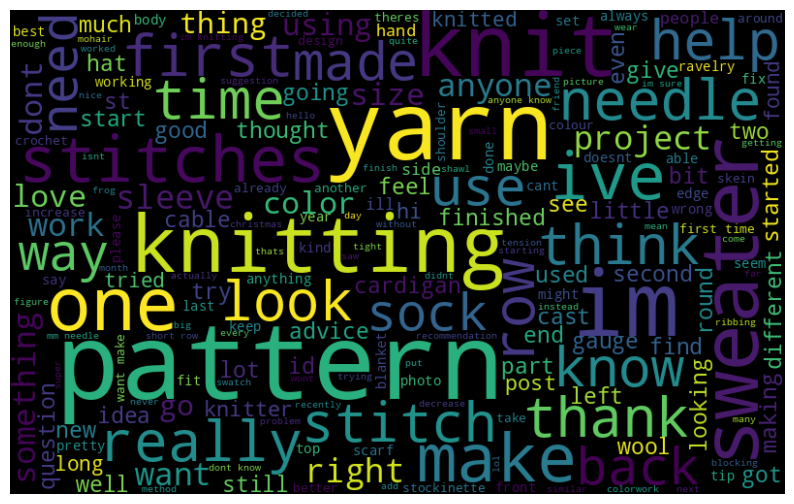

In [52]:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()